<a href="https://colab.research.google.com/github/miguel-fc/Neutron_Reflect/blob/main/nr_v10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/miguel-fc/Neutron_Reflect.git

Cloning into 'Neutron_Reflect'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 45 (delta 14), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (45/45), done.


In [2]:
# Import Python related required packages
import io
import os
import cv2
import gdown
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotly.express as px
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm
import pickle

#Import torch related packages
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset, TensorDataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
#Set these important parameters
#Dimension of the latent space 
d = 3
#Dimension of the graphs
in_d1 = 2
in_d2 = 96
#Number of epochs
num_epochs = 120
#Number of layers
num_layers = 1

In [4]:
cd Neutron_Reflect/

/content/Neutron_Reflect


In [5]:
#Stored those numpy arrays
data_path = './data/'
sld_arr = np.load(os.path.join(data_path,'sld_fp49.npy'))
params_arr = np.load(os.path.join(data_path,'params_fp49.npy'))

In [6]:
sld_arr.shape, params_arr.shape, sld_arr.dtype, params_arr.dtype

((5942, 2, 96), (5942, 3), dtype('float64'), dtype('float64'))

In [7]:
#Import packages from the github clone
from data_preparation import *
import AutoEnc
from fitting import *

In [8]:
xtrain, ytrain, xval, yval, xtest, ytest = \
split_input_arrays(sld_arr,params_arr, size_split=0.8)

xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape
(4753, 2, 96) (4753, 3) (594, 2, 96) (594, 3) (595, 2, 96) (595, 3)


In [9]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = \
get_dataloaders_fromsplitarrays(xtrain,ytrain,xval,yval,xtest,ytest,batch_size=50)

In [10]:
loss_fn = torch.nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [11]:
def initialize_model(in_d1,in_d2,num_layers):
  lr= 0.001
  torch.manual_seed(0)
  
  encoder = AutoEnc.Encoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers)
  decoder = AutoEnc.Decoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers)

  params_to_optimize = [
     {'params': encoder.parameters()},
     {'params': decoder.parameters()}
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return encoder, decoder, optim

In [12]:
encoder, decoder, optim = initialize_model(in_d1,in_d2,num_layers)

In [13]:
#Move encoder to device
encoder.to(device)

Encoder(
  (encoder): Sequential(
    (0): Linear(in_features=192, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=3, bias=True)
  )
)

In [14]:
#Move decoder to device
decoder.to(device)

Decoder(
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=192, bias=True)
  )
)

In [15]:
encoder, decoder, optim = initialize_model(in_d1,in_d2,num_layers)
# num_epochs = 120
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
  val_loss = valid_epoch(encoder,decoder,device,valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)
  # plot_ae_outputs(model,train_dataset,device,n=10)

EPOCH 1/120 	 train loss 0.08687404543161392 	 val loss 0.036844074726104736
EPOCH 2/120 	 train loss 0.015034683048725128 	 val loss 0.0004158992669545114
EPOCH 3/120 	 train loss 0.00022040533076506108 	 val loss 0.0002570555079728365
EPOCH 4/120 	 train loss 0.00018810213077813387 	 val loss 0.00023499559029005468
EPOCH 5/120 	 train loss 0.00017072407354135066 	 val loss 0.00022811148664914072
EPOCH 6/120 	 train loss 0.00015946553321555257 	 val loss 0.0002085733722196892
EPOCH 7/120 	 train loss 0.00015213976439554244 	 val loss 0.00021027693583164364
EPOCH 8/120 	 train loss 0.000145027443068102 	 val loss 0.0001908136036945507
EPOCH 9/120 	 train loss 0.00013868063979316503 	 val loss 0.00017999352712649852
EPOCH 10/120 	 train loss 0.00013163738185539842 	 val loss 0.00016731148934923112
EPOCH 11/120 	 train loss 0.00012407440226525068 	 val loss 0.00015600462211295962
EPOCH 12/120 	 train loss 0.00011896339128725231 	 val loss 0.0001506051339674741
EPOCH 13/120 	 train loss 0

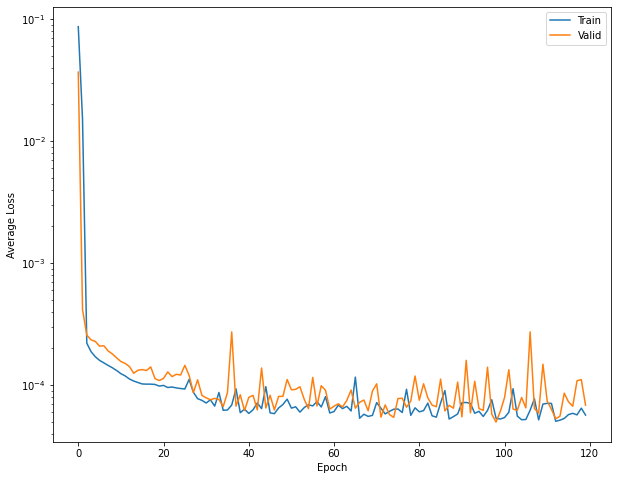

In [16]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

For image 0, the loss = 0.00012090635573258623
For image 1, the loss = 0.00011324919614708051
For image 2, the loss = 0.00011660659220069647
For image 3, the loss = 3.7365865864558145e-05
For image 4, the loss = 4.58232534583658e-05
For image 5, the loss = 0.00011675535643007606
For image 6, the loss = 0.00011353778972988948
For image 7, the loss = 2.512900209694635e-05
For image 8, the loss = 0.00021401657431852072
For image 9, the loss = 0.0001380398462060839


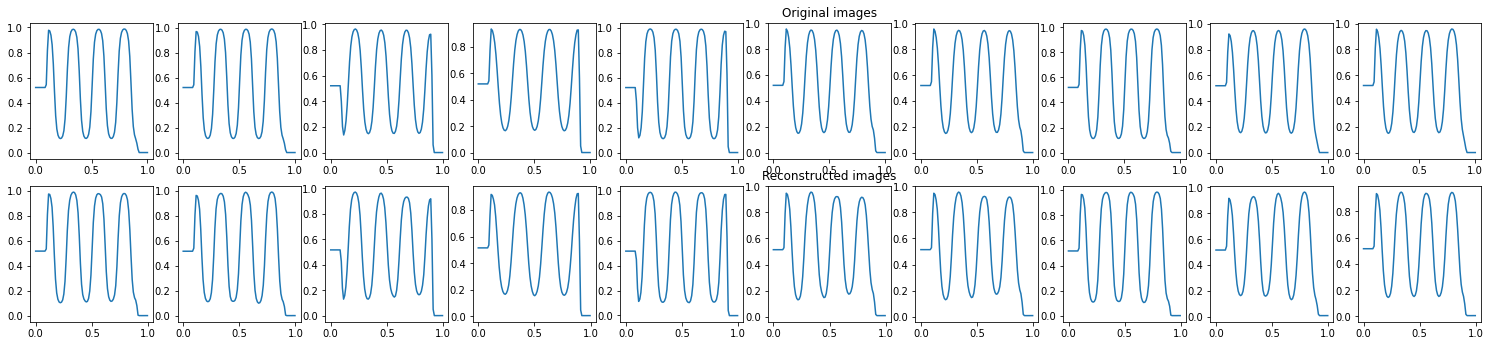

In [17]:
#Seeing how the model performs for the test unseen data. For this we choose 10 figures
#running through model.eval() and compute the loss plus we look at them visually

#Similar to plot_ae_outputs, except that this is one used to see the loss for 
#data in the test_loader. It also prints the loss for each
def plot_test_outputs(encoder,decoder,dataset,device,n=10):
    plt.figure(figsize=(26,5.5))
    for i in range(10):
      ax = plt.subplot(2,n,i+1)
      img,_ = dataset[i]
      #Notice that below i'm loading an image only, so it needs to be flatten
      #before entering the network
      img = torch.flatten(img).to(device)
      encoder.eval().to(device)
      decoder.eval().to(device)
      with torch.no_grad():
         decoded_img  = decoder(encoder(img))
         loss = loss_fn(decoded_img,img)
         print('For image {}, the loss = {}'.format(i,loss.data))
      plt.plot(img.cpu().reshape(in_d1,in_d2).numpy()[0],img.cpu().reshape(in_d1,in_d2).numpy()[1]) 
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n) 
      plt.plot(decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1]) 
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  


plot_test_outputs(encoder,decoder,test_dataset,device,n=10)

In [18]:
#Running the autoencoder on the train data. The goal here is to obtain the
#latent variables so they can be plot and also for training a MLP

def get_latent_variables(encoder, decoder, device, dataloader):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): 
        # Define the lists to store the original images, the recreated ones,
        # the latent variables and the corresponding labels
        list_img = []
        list_decoded_img = []
        list_latent = []
        list_labels = []

        for  data, label in dataloader:
            img = data
            img = img.view(img.size(0), -1).to(device) 
            # Encode and Decode data
            latent = encoder(img)
            decoded_img = decoder(latent)
            # Append the network output and the original image to the lists
            list_img.append(img.cpu())
            list_decoded_img.append(decoded_img.cpu())
            list_latent.append(latent.cpu())
            list_labels.append(label.cpu())
# Convert list into a torch.tensor
        t_img = torch.cat(list_img)
        t_decoded_img = torch.cat(list_decoded_img)
        t_latent = torch.cat(list_latent) 
        t_labels = torch.cat(list_labels)
    return t_img, t_decoded_img, t_latent, t_labels

tensor([-2.4824, -0.3689,  3.9871])
tensor([2.0852, 2.9598, 1.0958])


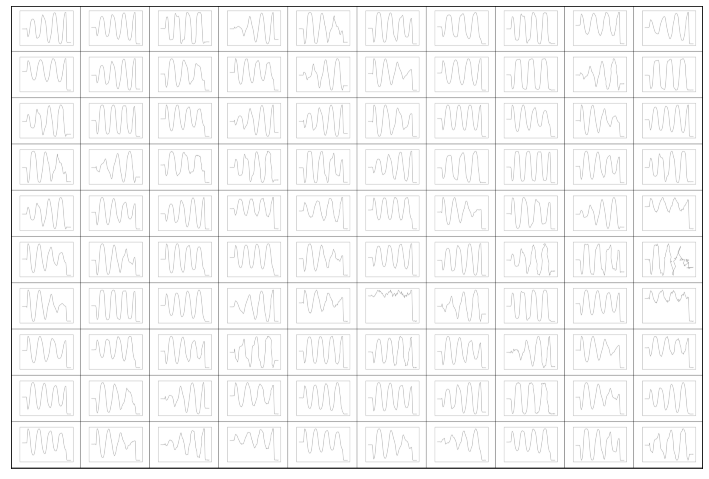

In [19]:
#Interpolating in the latent space

def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    plt.close()
    img = cv2.imdecode(img_arr,0)

    return img

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_xticks([])
    ax.set_yticks([])

encoder.eval()
decoder.eval()

with torch.no_grad():
    images, labels = iter(train_loader).next()
    images = images.view(images.size(0), -1).to(device) 

    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)


    latent = torch.randn(200, d)*std + mean
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.view(img_recon.size(0), in_d1,in_d2).cpu()


n_img = []
for i in range(img_recon.shape[0]):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.close()
    ax.plot(img_recon[i][0],img_recon[i][1])
    n_img.append(get_img_from_fig(fig))

n_img = torch.from_numpy(np.asarray(n_img))
n_img = n_img[:,np.newaxis,:,:]

fig, ax = plt.subplots(figsize=(20, 8.5))
show_image(torchvision.utils.make_grid(n_img[:100],10,5))
plt.show()

In [20]:
nlabel = params_arr.shape[1]
# nlabel

for i in range(nlabel):
  label_index = 'label'+str(i)
  print(label_index)

label0
label1
label2


In [21]:
encoded_samples = []
for sample in train_dataset:
    img = sample[0].unsqueeze(0)
    img = img.view(img.size(0), -1).to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    encoded_img = encoded_img.flatten().cpu().numpy()
    # print(enumerate(encoded_img))
    encoded_sample = {f"l{i+1}": enc for i, enc in enumerate(encoded_img)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      encoded_sample[label_index] = label_val[i].numpy()
    # encoded_sample['label1'] = label[1].numpy()
    # encoded_sample['label2'] = label[2].numpy()
    # encoded_sample['label3'] = label[3].numpy()
    encoded_samples.append(encoded_sample)
df_encoded_samples = pd.DataFrame(encoded_samples)
df_encoded_samples

,l1,l2,l3,label0,label1,label2
0,-2.629839,3.629749,4.301307,0.15,-0.555,-0.0734
1,-2.762100,3.581420,4.224980,0.194,-0.296,0.59049
2,-5.558299,-0.990308,2.401578,0.2,0.282,0.53083
3,-5.033463,-0.875110,2.666768,0.0741,0.47,0.33375
4,-5.554360,-0.933066,2.409992,0.164,0.592,0.15885
...,...,...,...,...,...,...
4748,0.548164,-0.035049,5.559164,0.0727,-0.146,-0.55033
4749,-2.446428,-4.508216,3.613447,0.191,0.57,-0.5212
4750,-5.532389,-0.968085,2.415269,0.109,0.369,0.42558
4751,-5.556540,-1.008692,2.400568,0.139,0.135,0.55506


In [22]:
#Creating dataloaders for the MLP. This includes train, valid and test
#Saving them on disk too

img, out_img, train_latent_var, train_labels_var = get_latent_variables(encoder,decoder,device,train_loader)
print(img.shape, out_img.shape, train_latent_var.shape, train_labels_var.shape)

img, out_img, valid_latent_var, valid_labels_var = get_latent_variables(encoder,decoder,device,valid_loader)
print(img.shape, out_img.shape, valid_latent_var.shape, valid_labels_var.shape)


img, out_img, test_latent_var, test_labels_var = get_latent_variables(encoder,decoder,device,test_loader)
print(img.shape, out_img.shape, test_latent_var.shape, test_labels_var.shape)


mlp_train_dataset, mlp_valid_dataset, mlp_test_dataset, mlp_train_loader, mlp_valid_loader, mlp_test_loader = \
get_dataloaders_fromsplitarrays(train_latent_var.numpy(),train_labels_var.numpy(), \
                                valid_latent_var.numpy(),valid_labels_var.numpy(),\
                                test_latent_var.numpy(),test_labels_var.numpy(), \
                                batch_size=50)

torch.Size([4753, 192]) torch.Size([4753, 192]) torch.Size([4753, 3]) torch.Size([4753, 3])
torch.Size([594, 192]) torch.Size([594, 192]) torch.Size([594, 3]) torch.Size([594, 3])
torch.Size([595, 192]) torch.Size([595, 192]) torch.Size([595, 3]) torch.Size([595, 3])


In [23]:
#Saving data into GitHub

torch.save(train_latent_var,os.path.join(data_path,'train_latent_var.pt'))
# torch.save(train_latent_var,'train_labels_var.pt')

# torch.save(valid_latent_var,'valid_latent_var.pt')
# torch.save(valid_latent_var,'valid_labels_var.pt')

# torch.save(test_latent_var,'test_latent_var.pt')
# torch.save(test_latent_var,'test_labels_var.pt')


# torch.save(mlp_train_loader,'mlp_train_loader.pth')
# torch.save(mlp_valid_loader,'mlp_valid_loader.pth')
# torch.save(mlp_test_loader,'mlp_test_loader.pth')

# !mv mlp_train_loader.pth /content/drive/MyDrive/neutron_reflectivity/
# !mv mlp_valid_loader.pth /content/drive/MyDrive/neutron_reflectivity/
# !mv mlp_test_loader.pth /content/drive/MyDrive/neutron_reflectivity/

# torch.save(mlp_test_dataset,'mlp_test_dataset.pth')
# !mv mlp_test_dataset.pth /content/drive/MyDrive/neutron_reflectivity/

# #Saving also the pandas dataframe for the encoded sample

# #Having issues with the way a saved .csv and loaded one look like. 
# # df_encoded_samples.to_csv('encoded.csv', sep ='\t')
# # !mv encoded.csv /content/drive/MyDrive/neutron_reflectivity/

# #Using pickle instead.
# df_encoded_samples.to_pickle('df_encoded_samples.pkl')
# !mv df_encoded_samples.pkl /content/drive/MyDrive/neutron_reflectivity/

In [24]:
# #Saving encoder and decoder 
# torch.save(encoder.state_dict(),"./encoder.pt")
# torch.save(decoder.state_dict(),"./decoder.pt")

In [25]:
# #Reloading the encoder and decoderen
# encoder.load_state_dict(torch.load("./encoder.pt"))
# decoder.load_state_dict(torch.load("./decoder.pt"))